In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('ggplot')
# figure size in inches
rcParams['figure.figsize'] = 8, 4

# pd.set_option('display.max_rows', None)

In [2]:
# Load csv files as data frames.
path = '../data/all-data/'
df1 = pd.read_csv(f'{path}Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv(f'{path}Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv(f'{path}Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv(f'{path}Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv(f'{path}Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv(f'{path}Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv(f'{path}Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv(f'{path}Wednesday-workingHours.pcap_ISCX.csv')

In [3]:
# Drop low count "Destination Port" from the 4th data frame (Benign activities data frame).
high_count_benign_ports = df4[' Destination Port'].value_counts()[:20].index
df4 = df4[df4[' Destination Port'].isin(high_count_benign_ports)]
df4.reset_index(drop=True, inplace=True)

In [28]:
# Remove etries labled "BENIGN" from all dataframes except the 4th data frame.
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
for i, df in enumerate(dfs):
    if i != 3:
        dfs[i] = dfs[i][dfs[i][' Label'] != 'BENIGN']

# Concatenate all data frames.
final_df = pd.concat(dfs)

# Print shape of the final data frame before updates.
print('Data frame shape before updates...')
print(final_df.shape, end='\n\n')

Data frame shape before updates...
(979537, 79)



In [29]:
# Remove extra spaces from feature names.
cols = final_df.columns.str.strip()
final_df.columns = cols

# Convert labels to lower case and replace column names spaces with "_".
cols = []
for i, col in enumerate(final_df.columns):
    new_col_name = col.lower()
    new_col_name = '_'.join(new_col_name.split())
    cols.append(new_col_name)
final_df.columns = cols

# Add new feature "is_intrusion" and make it's value for each entry 0.
final_df['is_intrusion'] = 0

# Chnage "is_intrusion" values for entries that are not labeled "benign" to 1.
final_df.loc[final_df['label'] != 'BENIGN', 'is_intrusion'] = 1

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(979537, 80)


In [30]:
# Drop columns that have the same value for all entries.
for i, col in enumerate(final_df.columns[:-2]):
    if (final_df[col] == final_df[col][0]).all():
        final_df = final_df.drop(columns=[col]) 

# Reset final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(979537, 70)


In [31]:
# Transform "labele" values to lower case.
final_df.label = final_df.label.str.lower()

# Group similar attacks.
final_df.loc[final_df['label'].str.startswith('dos'), 'label'] = 'dos'
final_df.loc[final_df['label'].str.startswith('web'), 'label'] = 'web_attack'
final_df.loc[final_df['label'].str.startswith('web'), 'label'] = 'web_attack'
final_df.loc[final_df['label'].str.endswith('patator'), 'label'] = 'brute_force'

# Drop entires that have Labels with low count (<100).
labeles_to_drop = final_df.label.value_counts()[-2:].index
final_df.drop(final_df.index[final_df['label'].isin(labeles_to_drop)], inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(979490, 70)


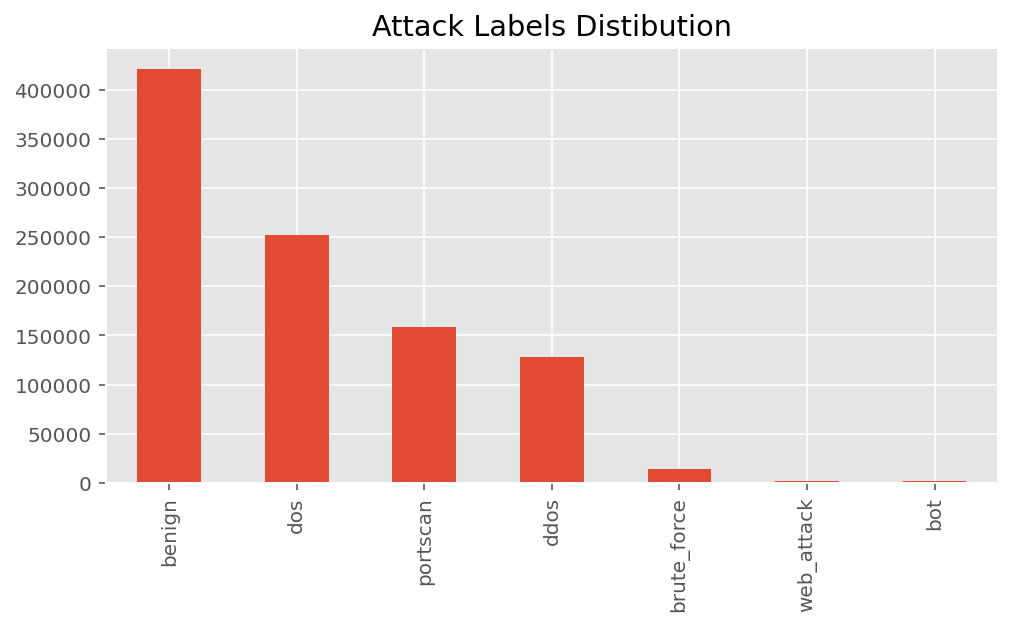

In [32]:
# Plot Attck Label distibution.
final_df.label.value_counts().plot.bar()
plt.title('Attack Labels Distibution')
plt.show()

In [33]:
# Check for Null values.
print('How many Null values are there?')
print(final_df.isnull().sum().sum(), end='\n\n')

# Replace Inf values with NaN.
final_df = final_df.replace([np.inf, -np.inf], np.nan)

# Drop all occurences of NaN.
print('Removing Null values...')
final_df = final_df.dropna()

# Rest final data frame indexes.      
final_df.reset_index(drop=True, inplace=True)

# Double check these are all gone.
print('\nHow many Null values are there?')
print(final_df.isnull().sum().sum(), end='\n\n')

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

How many Null values are there?
977

Removing Null values...

How many Null values are there?
0

Data frame shape after updates...
(978201, 70)


In [34]:
# Find duplicated features.
print('How many duplicated features are there?')
final_df.columns.duplicated().sum()

How many duplicated features are there?


0

In [35]:
# Find duplicated entries.
print('How many duplicated entries are there?')
print(final_df.duplicated().sum(), end='\n\n')

# Drop duplicated entries.
print('Droping duplicated entries...', end='\n\n')
final_df.drop_duplicates(inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Find duplicated entries.
print('How many duplicated entries are there?')
print(final_df.duplicated().sum(), end='\n\n')

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

How many duplicated entries are there?
157478

Droping duplicated entries

How many duplicated entries are there?
0

Data frame shape after updates...
(820723, 70)


In [36]:
# Drop bot attacks that has low "destination_port" count (==1).
# Note: these entries have the same values for all feature except for "destination_port".
low_port_count_bots_indexes = final_df[(final_df['label'] == 'bot') & (final_df['destination_port'] != 8080)].index
final_df.drop(low_port_count_bots_indexes, axis=0, inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(820022, 70)


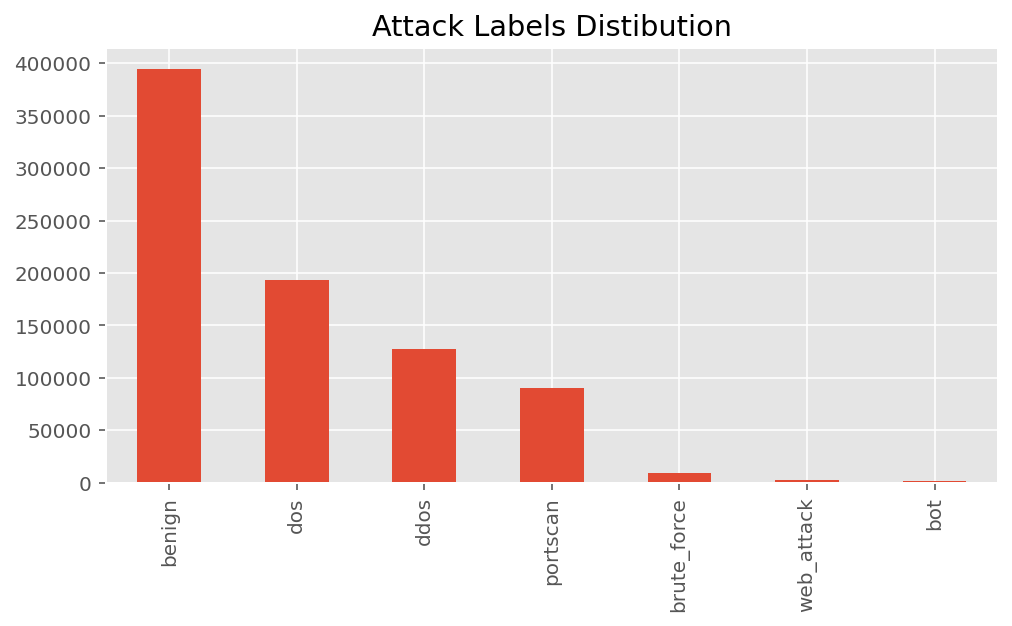

In [37]:
# Plot Attck Label distibution.
final_df.label.value_counts().plot.bar()
plt.title('Attack Labels Distibution')
plt.show()

In [15]:
# attacks = final_df.label.unique()
# for attack in attacks:
#     df = final_df[final_df['label'] == attack]
#     df.destination_port.value_counts().plot.bar()
#     plt.title(f'{attack.upper()} Port Distribution')
#     plt.show()

In [16]:
# Display features statistics.
final_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
destination_port,820022.0,1.090848e+03,5.218032e+03,0.0,53.0,80.0,443.00,6.538900e+04
flow_duration,820022.0,2.661319e+07,4.114619e+07,-1.0,23379.0,345720.5,65827564.75,1.200000e+08
total_fwd_packets,820022.0,8.881332e+00,7.174007e+02,1.0,2.0,3.0,7.00,2.197590e+05
total_backward_packets,820022.0,9.383624e+00,9.432153e+02,0.0,1.0,2.0,6.00,2.919220e+05
total_length_of_fwd_packets,820022.0,4.409074e+02,5.079992e+03,0.0,26.0,72.0,361.00,1.323378e+06
...,...,...,...,...,...,...,...,...
idle_mean,820022.0,2.055651e+07,3.628286e+07,0.0,0.0,0.0,10500000.00,1.200000e+08
idle_std,820022.0,1.147735e+06,7.144218e+06,0.0,0.0,0.0,0.00,7.514502e+07
idle_max,820022.0,2.143586e+07,3.715522e+07,0.0,0.0,0.0,10600000.00,1.200000e+08
idle_min,820022.0,1.970707e+07,3.614789e+07,0.0,0.0,0.0,9997715.75,1.200000e+08


In [17]:
final_df.corr(method='pearson')#.style.background_gradient(cmap="Greens", axis=0)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,is_intrusion
destination_port,1.000000,-0.116356,-0.001849,-0.001514,-0.010466,-0.001259,-0.075090,-0.070779,-0.093815,-0.080888,...,0.000699,-0.026625,-0.015519,-0.027379,-0.023275,-0.106369,-0.029831,-0.108252,-0.102454,0.161707
flow_duration,-0.116356,1.000000,0.013100,0.011942,0.065144,0.010563,0.298424,-0.215770,0.144429,0.334876,...,-0.004777,0.162204,0.163790,0.213585,0.116093,0.878381,0.254318,0.895285,0.844282,0.298548
total_fwd_packets,-0.001849,0.013100,1.000000,0.999318,0.838090,0.999013,0.017055,-0.003656,0.000647,0.002613,...,-0.000137,0.064333,0.006105,0.049270,0.068233,0.000218,0.000431,0.000297,0.000129,-0.005948
total_backward_packets,-0.001514,0.011942,0.999318,1.000000,0.838142,0.997307,0.016718,-0.003201,0.000160,0.001930,...,0.000015,0.063222,0.004309,0.047467,0.067930,-0.000348,-0.000203,-0.000371,-0.000342,-0.005905
total_length_of_fwd_packets,-0.010466,0.065144,0.838090,0.838142,1.000000,0.834369,0.318340,-0.017200,0.316383,0.267421,...,-0.002441,0.136325,0.120274,0.169219,0.101258,0.008135,0.006284,0.009792,0.006671,-0.043884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
idle_mean,-0.106369,0.878381,0.000218,-0.000348,0.008135,0.000092,0.184404,-0.186951,0.087495,0.255668,...,-0.003126,0.071615,-0.007431,0.040417,0.080242,1.000000,0.098490,0.989871,0.990129,0.422956
idle_std,-0.029831,0.254318,0.000431,-0.000203,0.006284,-0.000117,-0.015967,-0.058788,-0.021086,-0.015966,...,-0.003574,0.085403,0.098710,0.088104,0.049034,0.098490,1.000000,0.236283,-0.041627,0.118301
idle_max,-0.108252,0.895285,0.000297,-0.000371,0.009792,0.000064,0.178259,-0.191241,0.085130,0.248184,...,-0.003638,0.092470,0.022344,0.064054,0.089774,0.989871,0.236283,1.000000,0.960575,0.430401
idle_min,-0.102454,0.844282,0.000129,-0.000342,0.006671,0.000103,0.185918,-0.179044,0.089920,0.257698,...,-0.002640,0.057607,-0.022513,0.025695,0.071608,0.990129,-0.041627,0.960575,1.000000,0.408661


In [ ]:
fig = px.scatter(final_df, 'total_fwd_packets', 'total_backward_packets', color='label')
fig.layout.update({'height':700, 'width':900},  title_x=0.5)
# fig.update_layout(font=dict(size=20))
fig.show()

In [19]:
# Write the final data frame to a csv file. 
# final_df.to_csv(f'{path}intrusion_detection_data.csv', index=False)

In [3]:
df = pd.read_csv('../data/all-data/intrusion_detection_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820723 entries, 0 to 820722
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             820723 non-null  int64  
 1   flow_duration                820723 non-null  int64  
 2   total_fwd_packets            820723 non-null  int64  
 3   total_backward_packets       820723 non-null  int64  
 4   total_length_of_fwd_packets  820723 non-null  int64  
 5   total_length_of_bwd_packets  820723 non-null  int64  
 6   fwd_packet_length_max        820723 non-null  int64  
 7   fwd_packet_length_min        820723 non-null  int64  
 8   fwd_packet_length_mean       820723 non-null  float64
 9   fwd_packet_length_std        820723 non-null  float64
 10  bwd_packet_length_max        820723 non-null  int64  
 11  bwd_packet_length_min        820723 non-null  int64  
 12  bwd_packet_length_mean       820723 non-null  float64
 13 